# Setting Up

In [ ]:
pip install gerrychain[geo]

In [ ]:
# For working with graphs
import networkx as nx
# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrchain
import gerrychain
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPoint

# same randomness
import random
random.seed(123456)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Data and Merging Datasets together

## Joins
Because I want LA County census shapefile to combine with demographic data and voting data

In [ ]:
# Import Shapefile
la_county_gdf = gpd.read_file('/content/Census_Blocks_2020.shp')
print("Beginning of Data: ", la_county_gdf.head())
print("Names of Columns: ", la_county_gdf.columns)
print("Number of Rows: ", la_county_gdf.shape[0])
print("Number of Columns: ", la_county_gdf.shape[1])

Beginning of Data:     OBJECTID State COUNTY    CT20     BG20  CB20      CTCB20 FEAT_TYPE  FIP20  \
0         1    06    037  109300  1093002  2015  1093002015      Land  44000   
1         2    06    037  109300  1093001  1007  1093001007      Land  44000   
2         3    06    037  111100  1111001  1005  1111001005      Land  44000   
3         4    06    037  111202  1112023  3009  1112023009      Land  44000   
4         5    06    037  113101  1131011  1011  1131011011      Land  44000   

        BGFIP20  ...       HD_NAME SPA22      SPA_NAME SUP21   SUP_LABEL  \
0  109300244000  ...  San Fernando   2.0  San Fernando     3  District 3   
1  109300144000  ...  San Fernando   2.0  San Fernando     3  District 3   
2  111100144000  ...  San Fernando   2.0  San Fernando     3  District 3   
3  111202344000  ...  San Fernando   2.0  San Fernando     3  District 3   
4  113101144000  ...   West Valley   2.0  San Fernando     3  District 3   

  POP20  HOUSING20    ShapeSTAre   ShapeST

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


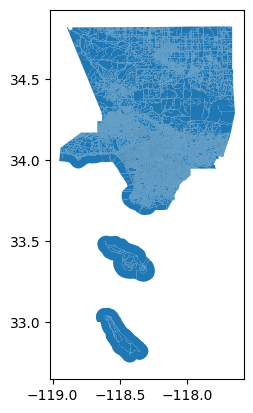

In [ ]:
la_county_gdf.plot()

In [ ]:
#shp file with voting data
ca_gdf = gpd.read_file("/content/ca_2020_gen_2020_blocks.shp")
print(ca_gdf.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


           GEOID20 STATEFP COUNTYFP                 PRECINCTID  VAP_MOD  \
0  060014001001000      06      001  6001213100 - 213100 - 492        0   
1  060014001001001      06      001  6001213100 - 213100 - 492        0   
2  060014001001002      06      001  6001213100 - 213100 - 492        0   
3  060014001001003      06      001  6001213100 - 213100 - 492        0   
4  060014001001004      06      001  6001213100 - 213100 - 492        0   

   G20PREDBID  G20PRERTRU  G20PRELJOR  G20PREGHAW  G20PREAFUE  G20PREPLAR  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

                                            geometry  
0  POLYGON ((-122.23614 37.8823

In [ ]:
# getting LA COUNTY
ca_gdf_la = ca_gdf[ca_gdf['COUNTYFP']=='037']
ca_gdf_la.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

GEOID20 STATEFP COUNTYFP                       PRECINCTID  \
111325  060371011101000      06      037  060379000640A - 9000640A - 4516   
111326  060371011101001      06      037  060379000640A - 9000640A - 4516   
111327  060371011101002      06      037  060379000640A - 9000640A - 4516   
111328  060371011101003      06      037  060379000640A - 9000640A - 4516   
111329  060371011101004      06      037  060379000645B - 9000645B - 4110   

        VAP_MOD  G20PREDBID  G20PRERTRU  G20PRELJOR  G20PREGHAW  G20PREAFUE  \
111325       88       30.98       25.64        0.47        0.19        0.16   
111326       66       23.23       19.23        0.35        0.14        0.12   
111327       65       22.88       18.94        0.34        0.14        0.11   
111328       58       20.42       16.90        0.31        0.12        0.10   
111329      131       39.36       32.62        0.78        0.24        0.29   

        G20PREPLAR                                           geometry  
111325        0.09  POLYGON ((-118.28574 34.26264, -118.28491 34.2...  
111326        0.07  POLYGON ((-118.2868 34.2628, -118.28649 34.262...  
111327        0.07  POLYGON ((-118.28763 34.26281, -118.2868 34.26...  
111328        0.06  POLYGON ((-118.28847 34.26282, -118.28763 34.2...  
111329        0.20  POLYGON ((-118.2901 34.26145, -118.29007 34.26...

In [ ]:
# New census tract column (giving it the same name as in gdf)

ca_gdf_la['CT20'] = ca_gdf_la['GEOID20'].str[5:11]

# New census block column (giving it the same name as in gdf)
ca_gdf_la['CB20'] = ca_gdf_la['GEOID20'].str[11:15]

print(ca_gdf_la.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                GEOID20 STATEFP COUNTYFP                       PRECINCTID  \
111325  060371011101000      06      037  060379000640A - 9000640A - 4516   
111326  060371011101001      06      037  060379000640A - 9000640A - 4516   
111327  060371011101002      06      037  060379000640A - 9000640A - 4516   
111328  060371011101003      06      037  060379000640A - 9000640A - 4516   
111329  060371011101004      06      037  060379000645B - 9000645B - 4110   

        VAP_MOD  G20PREDBID  G20PRERTRU  G20PRELJOR  G20PREGHAW  G20PREAFUE  \
111325       88       30.98       25.64        0.47        0.19        0.16   
111326       66       23.23       19.23        0.35        0.14        0.12   
111327       65       22.88       18.94        0.34        0.14        0.11   
111328       58       20.42       16.90        0.31        0.12        0.10   
111329      131       39.36       32.62        0.78        0.24        0.29   

        G20PREPLAR                                           g

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# joining those dataframes together!
la_county_gdf_new = la_county_gdf.merge(ca_gdf_la, on = ['CT20', 'CB20'], how = 'left')

la_county_gdf_new.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['OBJECTID', 'State', 'COUNTY', 'CT20', 'BG20', 'CB20', 'CTCB20',
       'FEAT_TYPE', 'FIP20', 'BGFIP20', 'CITY', 'COMM', 'CITYCOMM', 'ZCTA20',
       'HD22', 'HD_NAME', 'SPA22', 'SPA_NAME', 'SUP21', 'SUP_LABEL', 'POP20',
       'HOUSING20', 'ShapeSTAre', 'ShapeSTLen', 'geometry_x', 'GEOID20',
       'STATEFP', 'COUNTYFP', 'PRECINCTID', 'VAP_MOD', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREAFUE', 'G20PREPLAR',
       'geometry_y'],
      dtype='object')

In [ ]:
# Check the geometry columns
print(la_county_gdf_new[['geometry_x', 'geometry_y']])

la_county_gdf_new = la_county_gdf_new.set_geometry('geometry_x')

# Rename the geometry column for clarity, if desired
la_county_gdf_new = la_county_gdf_new.rename(columns={'geometry_x': 'geometry'})

# Drop the unused geometry column (optional)
la_county_gdf_new = la_county_gdf_new.drop(columns=['geometry_y'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                              geometry_x  \
0      POLYGON ((-118.48023 34.26742, -118.48022 34.2...   
1      POLYGON ((-118.48477 34.26829, -118.48366 34.2...   
2      POLYGON ((-118.49722 34.26825, -118.4968 34.26...   
3      POLYGON ((-118.50662 34.26845, -118.50332 34.2...   
4      POLYGON ((-118.58422 34.26632, -118.58153 34.2...   
...                                                  ...   
91621  POLYGON ((-118.06451 34.12467, -118.06021 34.1...   
91622  POLYGON ((-118.16807 34.12393, -118.16779 34.1...   
91623  POLYGON ((-118.12745 34.12411, -118.12717 34.1...   
91624  POLYGON ((-118.2549 34.12413, -118.25484 34.12...   
91625  POLYGON ((-117.79182 34.12578, -117.79162 34.1...   

                                              geometry_y  
0      POLYGON ((-118.48022 34.26742, -118.48021 34.2...  
1      POLYGON ((-118.48476 34.26829, -118.48365 34.2...  
2      POLYGON ((-118.4972 34.26825, -118.49679 34.26...  
3      POLYGON ((-118.5066 34.26844, -118.5

# Looking at California

In [ ]:
california = gpd.read_file('/content/US_Congressional_Districts.shp')
california.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GEOID                 CongDistri CongDist_1    CongAreaSq  \
0    01  Congressional District 01      CD 01  27048.320750   
1    02  Congressional District 02      CD 02  13116.315889   
2    03  Congressional District 03      CD 03  22048.575163   
3    04  Congressional District 04      CD 04   3909.898521   
4    05  Congressional District 05      CD 05   9967.653956   

                                            geometry  
0  POLYGON ((-13358458.573 4825687.197, -13358492...  
1  MULTIPOLYGON (((-13628008.726 4560672.26, -136...  
2  POLYGON ((-13358458.573 4825687.197, -13358449...  
3  MULTIPOLYGON (((-13614204.997 4610539.439, -13...  
4  POLYGON ((-13175841.55 4403591.606, -13176183....

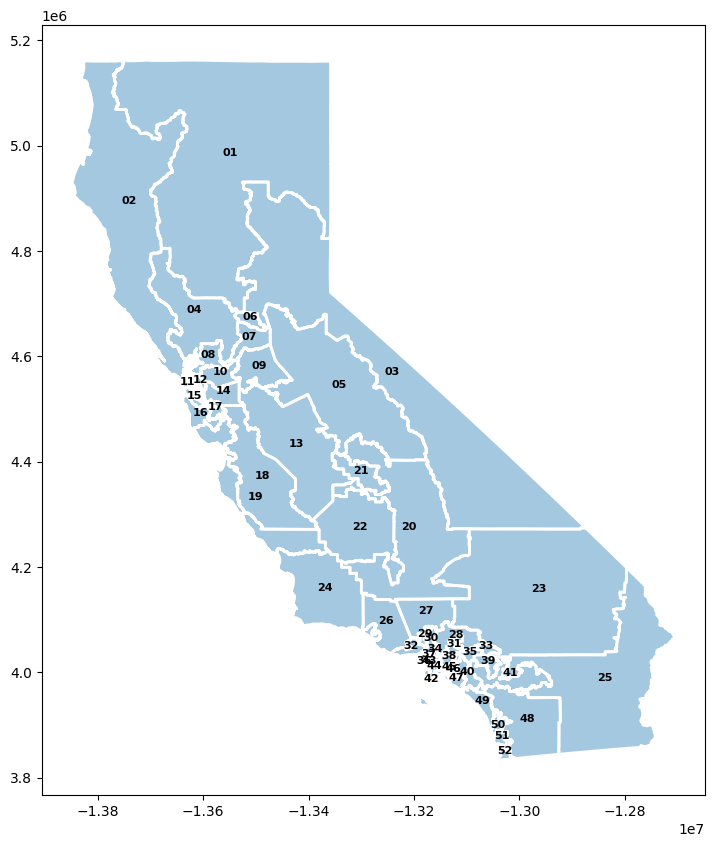

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
california.boundary.plot(ax=ax, linewidth=2, color='white')
california.plot(ax=ax, alpha=0.4, edgecolor='black')

# Add labels for each district at their centroids
for idx, row in california.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(row["GEOID"]),
            fontsize=8, ha='center', color='black', weight='bold')
# plt.axis('off')
plt.show()

In [ ]:
xmin, ymin, xmax, ymax = california.total_bounds
print(f"Bounds of the GeoDataFrame: xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}")

Bounds of the GeoDataFrame: xmin=-13849212.353943305, xmax=-12705029.569489492, ymin=3833656.0272024823, ymax=5162403.843219658


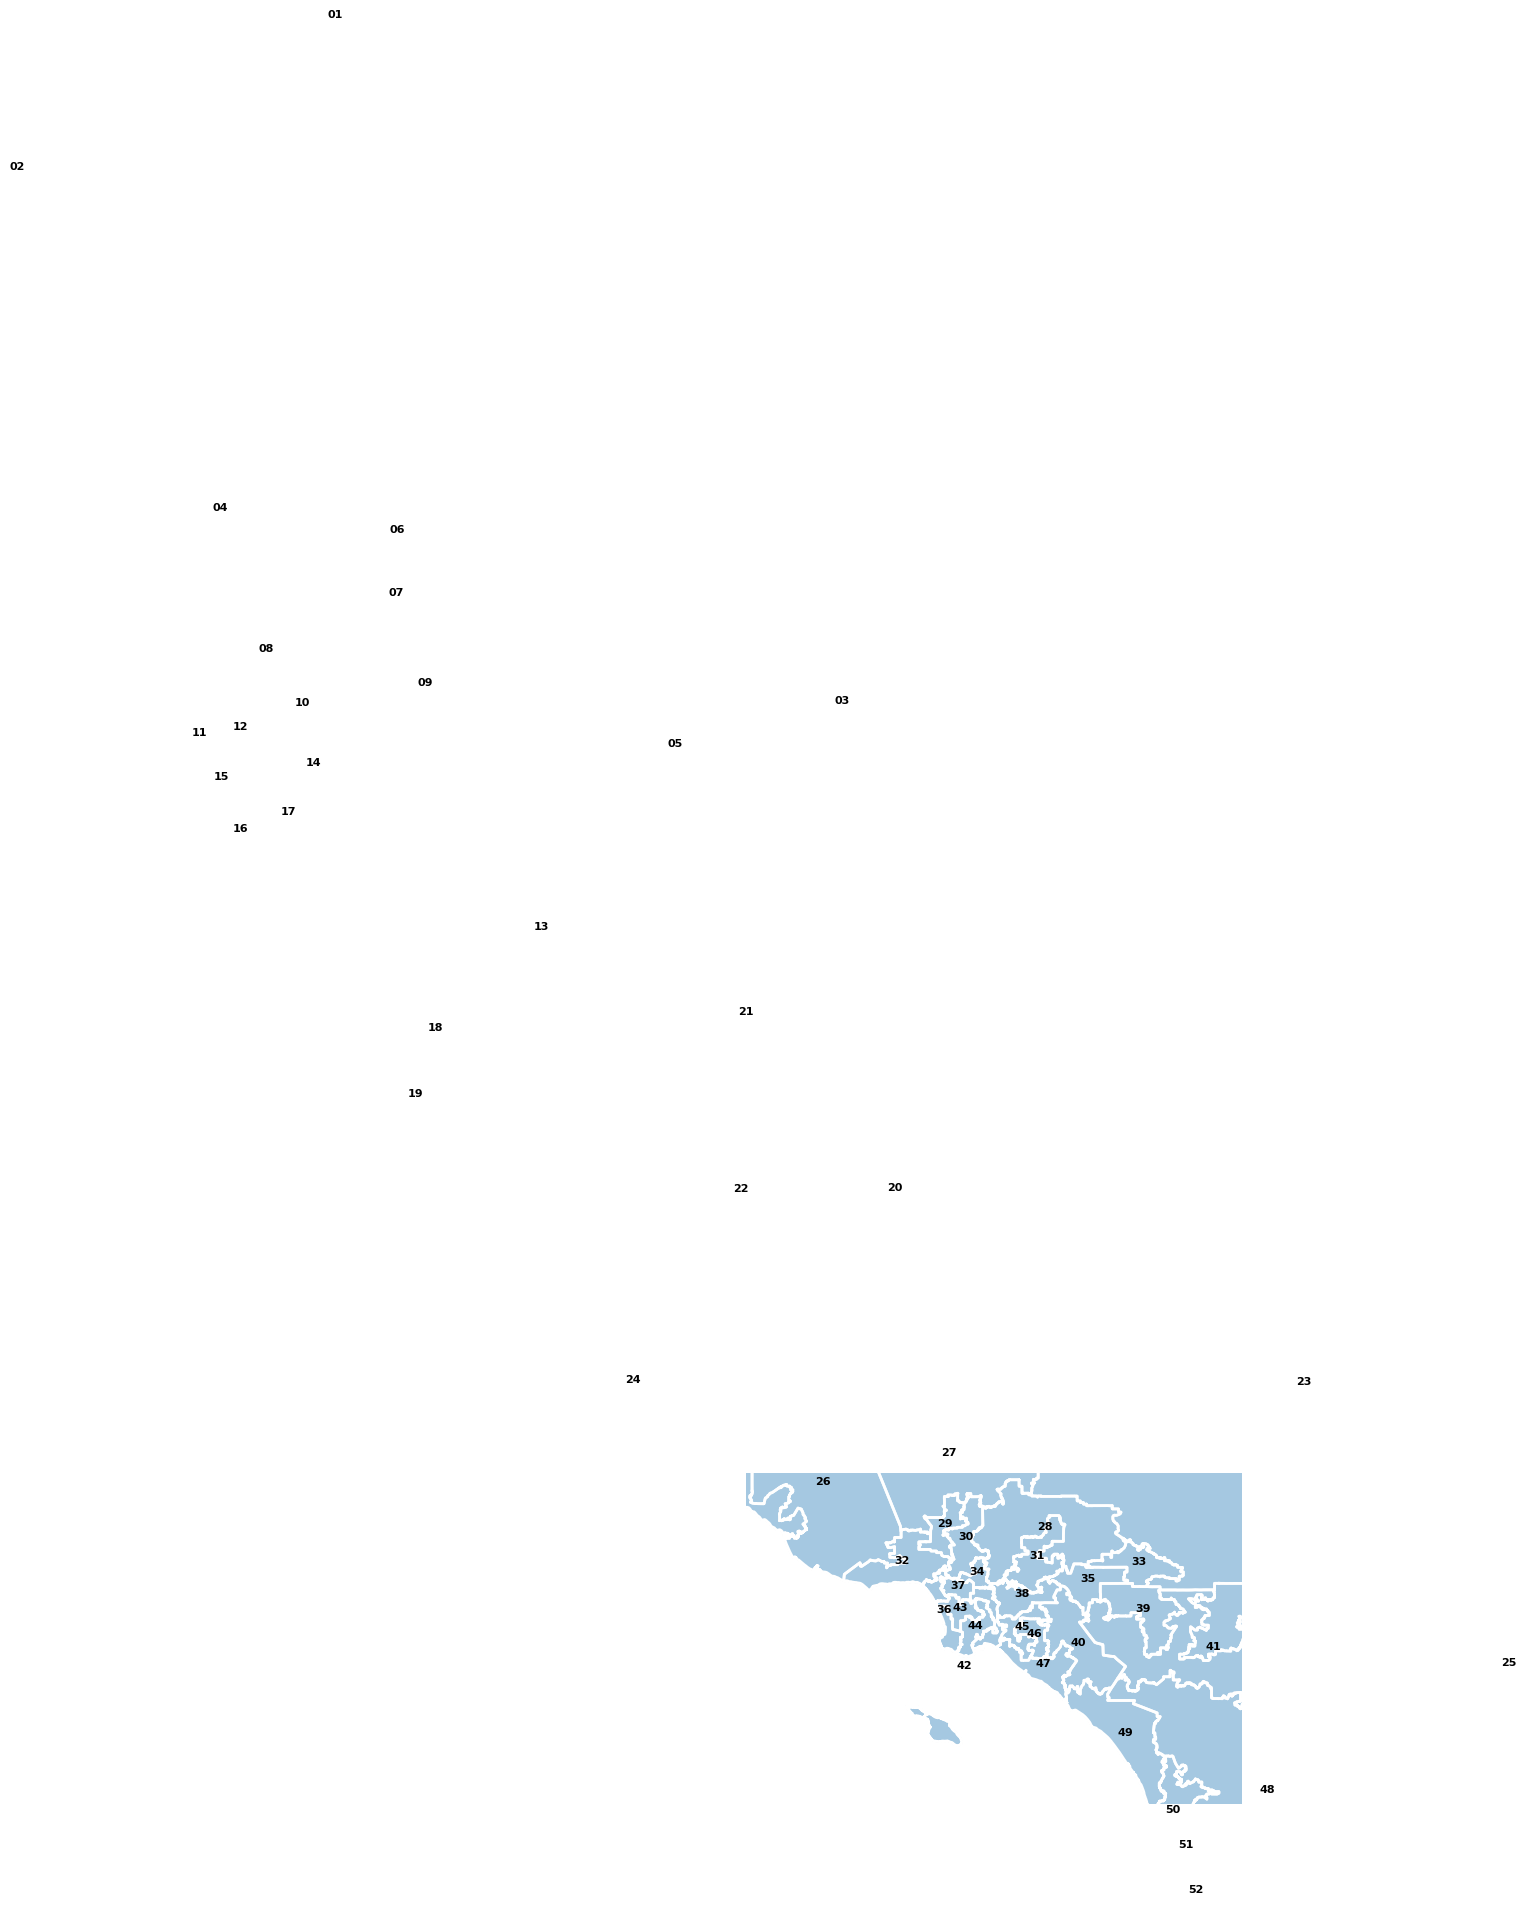

In [ ]:
fig, ax = plt.subplots()
california.boundary.plot(ax=ax, linewidth=2, color='white')
california.plot(ax=ax, alpha=0.4, edgecolor='black')

ax.set_xlim([-13300000, -13000000])
ax.set_ylim([3900000, 4100000])

# Add labels for each district at their centroids
for idx, row in california.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(row["GEOID"]),
            fontsize=8, ha='center', color='black', weight='bold')

plt.axis('off')
plt.show()

# LOOKING AT LA COUNTY

In [ ]:
la_blocks_race = pd.read_csv('/content/DECENNIALPL2020.P1-Data.csv')
print(la_blocks_race.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

                     GEO_ID  \
0                 Geography   
1  1000000US060371011101000   
2  1000000US060371011101001   
3  1000000US060371011101002   
4  1000000US060371011101003   

                                                NAME    P1_001N  \
0                               Geographic Area Name   !!Total:   
1  Block 1000, Block Group 1, Census Tract 1011.1...        101   
2  Block 1001, Block Group 1, Census Tract 1011.1...         81   
3  Block 1002, Block Group 1, Census Tract 1011.1...         75   
4  Block 1003, Block Group 1, Census Tract 1011.1...         76   

                              P1_002N  \
0   !!Total:!!Population of one race:   
1                                  95   
2                                  77   
3                                  65   
4                                  56   

                                           P1_003N  \
0   !!Total:!!Population of one race:!!White alone   
1                                               66   
2

<ipython-input-15-a04350ee1ed2>:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  la_blocks_race = pd.read_csv('/content/DECENNIALPL2020.P1-Data.csv')


Importing additional data

Data from: US Census

Select only the relevant columns
'GEO_ID': Unique to each census block, is what we'll use to combine data
'P1_001N': Total Population of each census block
'P1_006N': Asian population of each census block

In [ ]:
arc_city_race = la_blocks_race[['GEO_ID', 'P1_001N', 'P1_006N']]

arc_city_race2 = arc_city_race.rename(columns={'P1_001N': 'Total Population' , 'P1_006N': "Asian Population"})

arc_city_race2.columns
arc_city_race2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GEO_ID Total Population  \
0                     Geography         !!Total:   
1      1000000US060371011101000              101   
2      1000000US060371011101001               81   
3      1000000US060371011101002               75   
4      1000000US060371011101003               76   
...                         ...              ...   
91622  1000000US060379903000006                0   
91623  1000000US060379903000007                0   
91624  1000000US060379903000008                0   
91625  1000000US060379903000009                0   
91626  1000000US060379903000010                0   

                                      Asian Population  
0       !!Total:!!Population of one race:!!Asian alone  
1                                                    9  
2                                                    8  
3                                                    7  
4                                                    1  
...                                                ...  
91622                                                0  
91623                                                0  
91624                                                0  
91625                                                0  
91626                                                0  

[91627 rows x 3 columns]

In [ ]:
# New census tract column (giving it the same name as in gdf)

arc_city_race2['CT20'] = arc_city_race['GEO_ID'].str[14:20]

# New census block column (giving it the same name as in gdf)
arc_city_race2['CB20'] = arc_city_race['GEO_ID'].str[20:24]

print(arc_city_race2.head())
print(arc_city_race2.columns)

# Doing the join!
la_gdf_race = la_county_gdf_new.merge(arc_city_race2, on = ['CT20', 'CB20'], how = 'left')

la_gdf_race

                     GEO_ID Total Population  \
0                 Geography         !!Total:   
1  1000000US060371011101000              101   
2  1000000US060371011101001               81   
3  1000000US060371011101002               75   
4  1000000US060371011101003               76   

                                  Asian Population    CT20  CB20  
0   !!Total:!!Population of one race:!!Asian alone                
1                                                9  101110  1000  
2                                                8  101110  1001  
3                                                7  101110  1002  
4                                                1  101110  1003  
Index(['GEO_ID', 'Total Population', 'Asian Population', 'CT20', 'CB20'], dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OBJECTID State COUNTY    CT20     BG20  CB20      CTCB20 FEAT_TYPE  \
0             1    06    037  109300  1093002  2015  1093002015      Land   
1             2    06    037  109300  1093001  1007  1093001007      Land   
2             3    06    037  111100  1111001  1005  1111001005      Land   
3             4    06    037  111202  1112023  3009  1112023009      Land   
4             5    06    037  113101  1131011  1011  1131011011      Land   
...         ...   ...    ...     ...      ...   ...         ...       ...   
91621     91622    06    037  431800  4318003  3003  4318003003      Land   
91622     91623    06    037  463900  4639003  3012  4639003012      Land   
91623     91624    06    037  464102  4641023  3010  4641023010      Land   
91624     91625    06    037  302505  3025051  1015  3025051015      Land   
91625     91626    06    037  400207  4002072  2010  4002072010      Land   

       FIP20       BGFIP20  ... VAP_MOD G20PREDBID G20PRERTRU G20PRELJOR  \
0      44000  109300244000  ...      57      24.09      12.07       0.37   
1      44000  109300144000  ...      48      20.28      10.16       0.31   
2      44000  111100144000  ...      50      20.73      11.06       0.26   
3      44000  111202344000  ...      73      28.61      17.00       0.22   
4      44000  113101144000  ...     199      83.11      59.71       1.74   
...      ...           ...  ...     ...        ...        ...        ...   
91621  02462  431800302462  ...     366      94.74      56.92       1.08   
91622  56000  463900356000  ...       0       0.00       0.00       0.00   
91623  68224  464102368224  ...      27      11.95       8.21       0.25   
91624  30000  302505130000  ...       0       0.00       0.00       0.00   
91625  40830  400207240830  ...      62      27.34      29.33       0.74   

       G20PREGHAW G20PREAFUE  G20PREPLAR                    GEO_ID  \
0            0.20       0.15        0.17  1000000US060371093002015   
1            0.17       0.12        0.14  1000000US060371093001007   
2            0.16       0.22        0.22  1000000US060371111001005   
3            0.07       0.14        0.22  1000000US060371112023009   
4            0.62       0.49        0.42  1000000US060371131011011   
...           ...        ...         ...                       ...   
91621        0.90       0.18        0.18  1000000US060374318003003   
91622        0.00       0.00        0.00  1000000US060374639003012   
91623        0.11       0.08        0.04  1000000US060374641023010   
91624        0.00       0.00        0.00  1000000US060373025051015   
91625        0.05       0.24        0.13  1000000US060374002072010   

      Total Population Asian Population  
0                   80               10  
1                   63                7  
2                   56               13  
3                   99               30  
4                  242               61  
...                ...              ...  
91621              433              277  
91622                0                0  
91623               34               22  
91624                0                0  
91625               72               13  

[91626 rows x 39 columns]

In [ ]:
# True/False for each row if 'Asian Population' is null
pd.isna(la_gdf_race['Asian Population'])

# Keep only rows corresponding to true
la_gdf_race[pd.isna(la_gdf_race['Asian Population'])]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Empty GeoDataFrame
Columns: [OBJECTID, State, COUNTY, CT20, BG20, CB20, CTCB20, FEAT_TYPE, FIP20, BGFIP20, CITY, COMM, CITYCOMM, ZCTA20, HD22, HD_NAME, SPA22, SPA_NAME, SUP21, SUP_LABEL, POP20, HOUSING20, ShapeSTAre, ShapeSTLen, geometry, GEOID20, STATEFP, COUNTYFP, PRECINCTID, VAP_MOD, G20PREDBID, G20PRERTRU, G20PRELJOR, G20PREGHAW, G20PREAFUE, G20PREPLAR, GEO_ID, Total Population, Asian Population]
Index: []

[0 rows x 39 columns]

In [ ]:
la_gdf_race.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['OBJECTID', 'State', 'COUNTY', 'CT20', 'BG20', 'CB20', 'CTCB20',
       'FEAT_TYPE', 'FIP20', 'BGFIP20', 'CITY', 'COMM', 'CITYCOMM', 'ZCTA20',
       'HD22', 'HD_NAME', 'SPA22', 'SPA_NAME', 'SUP21', 'SUP_LABEL', 'POP20',
       'HOUSING20', 'ShapeSTAre', 'ShapeSTLen', 'geometry', 'GEOID20',
       'STATEFP', 'COUNTYFP', 'PRECINCTID', 'VAP_MOD', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREAFUE', 'G20PREPLAR',
       'GEO_ID', 'Total Population', 'Asian Population'],
      dtype='object')

In [ ]:
la_gdf_race = la_gdf_race.set_geometry('geometry')

In [ ]:
print(la_gdf_race.geometry.name)  # Should output 'geometry' or the correct column name

geometry


## More Visualizations

<Axes: >

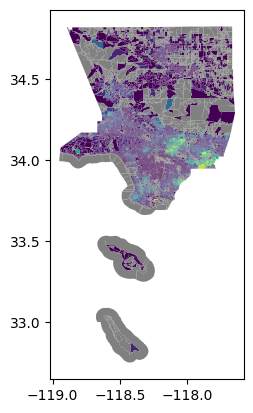

In [ ]:
# calculating Asian population fraction
la_gdf_race['a_frac'] = pd.to_numeric(la_gdf_race['Asian Population'])/pd.to_numeric(la_gdf_race['POP20'])
la_gdf_race.plot(column = 'a_frac', missing_kwds = {'color': 'grey'})

In [ ]:
# calculating Republican vs Democratic dominance

# Calculate the ratio of Republican to Democratic votes
la_gdf_race['R_to_D_ratio'] = la_gdf_race['G20PRERTRU'] / (la_gdf_race['G20PREDBID'] + 1e-10)  # Adding a small value to avoid division by zero

# Create a categorical column for better visualization
la_gdf_race['R_or_D'] = np.where(la_gdf_race['R_to_D_ratio'] > 1, 'Trump', 'Biden')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Get the relevant columns
# Convert the 'Asian Population' column to numeric
la_gdf_race['Asian Population'] = pd.to_numeric(la_gdf_race['Asian Population'], errors='coerce')
la_votes = la_gdf_race[['SUP21', 'Asian Population', 'POP20','geometry', 'G20PRERTRU', 'G20PREDBID']]
la_by_dist = la_votes.dissolve(by="SUP21", aggfunc =
{
    'Asian Population': 'sum',
    'POP20': 'sum',
    'G20PRERTRU': 'sum',
    'G20PREDBID': 'sum'
}).reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
la_by_dist['a_frac'] = la_by_dist['Asian Population']/la_by_dist['POP20']

# calculating Republican vs Democratic dominance

# Calculate the ratio of Republican to Democratic votes
la_by_dist['R_to_D_ratio'] = la_by_dist['G20PRERTRU'] / (la_by_dist['G20PREDBID'] + 1e-10)  # Adding a small value to avoid division by zero

# Create a categorical column for better visualization
la_by_dist['R_or_D'] = np.where(la_by_dist['R_to_D_ratio'] > 1, 'Trump', 'Biden')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
la_by_dist.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['SUP21', 'geometry', 'Asian Population', 'POP20', 'G20PRERTRU',
       'G20PREDBID', 'a_frac', 'R_to_D_ratio', 'R_or_D'],
      dtype='object')

In [ ]:
la_by_dist

SUP21                                           geometry  Asian Population  \
0     1  POLYGON ((-118.28402 34.03712, -118.28402 34.0...            500087   
1     2  POLYGON ((-118.4662 33.81744, -118.46682 33.81...            206808   
2     3  POLYGON ((-118.64836 33.98673, -118.65017 33.9...            240375   
3     4  MULTIPOLYGON (((-118.56142 33.08107, -118.5526...            268521   
4     5  POLYGON ((-118.62565 34.27489, -118.62586 34.2...            284193   

     POP20  G20PRERTRU  G20PREDBID    a_frac  R_to_D_ratio R_or_D  
0  1975618   184901.21   543699.09  0.253129      0.340080  Biden  
1  2011826   131187.72   625009.89  0.102796      0.209897  Biden  
2  2055731   245335.54   693501.78  0.116929      0.353763  Biden  
3  2077325   259951.50   596139.86  0.129263      0.436058  Biden  
4  1893509   324132.41   570479.96  0.150088      0.568175  Biden

In [ ]:
# Filter for districts where a_frac > 0.5
high_a_frac_districts = la_by_dist[la_by_dist['a_frac'] >= 0.5]

# Count the total districts
total_high_a_frac = high_a_frac_districts.shape[0]
print(f"Total districts with a_frac > 0.5: {total_high_a_frac}")

Total districts with a_frac > 0.5: 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Further filter for districts where R_or_D = 'Biden'
biden_districts = la_by_dist[la_by_dist['R_or_D'] == 'Biden']

# Count the total districts
total_biden_majority = biden_districts.shape[0]
print(f"Total districts with Biden as the majority: {total_biden_majority}")

Total districts with Biden as the majority: 5


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Assuming Arcadia's geometry is in the GeoDataFrame `la_by_dist` with a unique identifier
arcadia_row = la_gdf_race[la_gdf_race["CITY"] == "Arcadia"].iloc[0]
arcadia_point = arcadia_row.geometry.representative_point()

# Extract Arcadia's coordinates
arcadia_x, arcadia_y = arcadia_point.x, arcadia_point.y


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


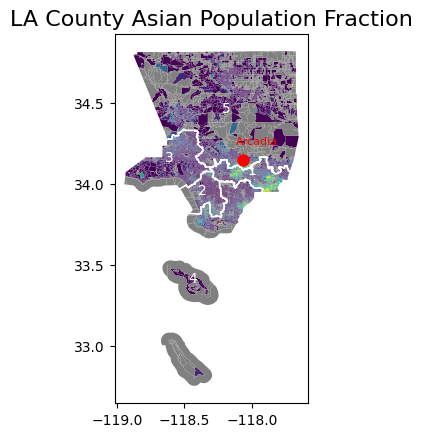

In [ ]:
# Calculate representative points for labeling
la_by_dist["rep_point"] = la_by_dist.geometry.representative_point()

# Extract x and y coordinates of representative points
la_by_dist["label_x"] = la_by_dist["rep_point"].x
la_by_dist["label_y"] = la_by_dist["rep_point"].y

# Make empty figure and axes
fig, ax = plt.subplots()

# Plot colors and lines using the same axis
a_plot = la_gdf_race.plot(column="a_frac", ax=ax, missing_kwds={'color': 'grey'})
la_by_dist.boundary.plot(ax=ax, color='white', linewidth=1)

# Add labels using representative points
for _, row in la_by_dist.iterrows():
    district_label = row["SUP21"]
    ax.text(row["label_x"], row["label_y"], district_label, ha="center", fontsize=10, color="white")

# Add Arcadia's point and label
ax.plot(arcadia_x, arcadia_y, marker="o", color="red", markersize=8, label="Arcadia")
ax.text(arcadia_x+0.1, arcadia_y+0.1, "Arcadia", ha="center", fontsize=8, color="red")

# Add a title
ax.set_title('LA County Asian Population Fraction', fontsize=16)

# Show your figure
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


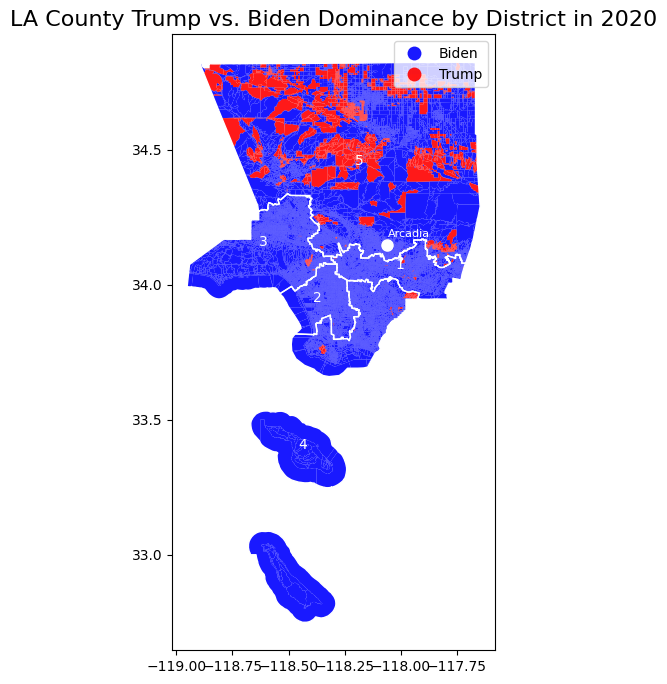

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the districts with colors based on Republican or Democratic dominance
la_gdf_race.plot(
    column='R_or_D',          # Column for categorical data (Republican or Democratic)
    cmap='bwr',               # Color scheme for clear distinction (blue for D, red for R)
    ax=ax,
    legend=True,              # Add a colorbar for the categories
    alpha=0.9                 # Less transparency for better visibility
)

la_by_dist.boundary.plot(ax = ax, color = 'white', linewidth = 1)

# Add labels using representative points
for _, row in la_by_dist.iterrows():
    district_label = row["SUP21"]
    ax.text(row["label_x"], row["label_y"], district_label, ha="center", fontsize=10, color="white")


# Add Arcadia's point and label
ax.plot(arcadia_x, arcadia_y, marker="o", color="white", markersize=8, label="Arcadia")
ax.text(arcadia_x+0.1, arcadia_y+0.03, "Arcadia", ha="center", fontsize=8, color="white")

# Add a title
ax.set_title('LA County Trump vs. Biden Dominance by District in 2020', fontsize=16)

# Display the plot
plt.show()

# ONLY LOOKING AT ARCADIA

## more data cleaning

Number of Rows:  479


<Axes: >

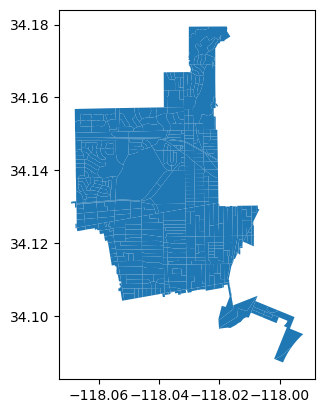

In [ ]:
arc_city_gdf = la_county_gdf[la_county_gdf['CITY'] == "Arcadia"]



print("Number of Rows: ", arc_city_gdf.shape[0])
arc_city_gdf.plot()

Join by pulling out substrings of GEOID

In [ ]:
# New census tract column (giving it the same name as in gdf)

arc_city_race2['CT20'] = arc_city_race['GEO_ID'].str[14:20]

# New census block column (giving it the same name as in gdf)
arc_city_race2['CB20'] = arc_city_race['GEO_ID'].str[20:24]

print(arc_city_race2.head())
print(arc_city_race2.columns)

# Doing the join!
arc_city_gdf_race = arc_city_gdf.merge(arc_city_race2, on = ['CT20', 'CB20'], how = 'left')

arc_city_gdf_race

                     GEO_ID Total Population  \
0                 Geography         !!Total:   
1  1000000US060371011101000              101   
2  1000000US060371011101001               81   
3  1000000US060371011101002               75   
4  1000000US060371011101003               76   

                                  Asian Population    CT20  CB20  
0   !!Total:!!Population of one race:!!Asian alone                
1                                                9  101110  1000  
2                                                8  101110  1001  
3                                                7  101110  1002  
4                                                1  101110  1003  
Index(['GEO_ID', 'Total Population', 'Asian Population', 'CT20', 'CB20'], dtype='object')


OBJECTID State COUNTY    CT20     BG20  CB20      CTCB20 FEAT_TYPE  \
0         465    06    037  430701  4307014  4005  4307014005      Land   
1         471    06    037  430400  4304004  4009  4304004009      Land   
2         472    06    037  430701  4307014  4004  4307014004      Land   
3         553    06    037  430600  4306003  3008  4306003008      Land   
4         554    06    037  430600  4306003  3010  4306003010      Land   
..        ...   ...    ...     ...      ...   ...         ...       ...   
474     91167    06    037  431600  4316002  2013  4316002013      Land   
475     91430    06    037  430701  4307014  4000  4307014000      Land   
476     91609    06    037  430724  4307241  1004  4307241004      Land   
477     91619    06    037  431701  4317015  5002  4317015002      Land   
478     91622    06    037  431800  4318003  3003  4318003003      Land   

     FIP20       BGFIP20  ... SUP21   SUP_LABEL POP20 HOUSING20  \
0    02462  430701402462  ...     5  District 5    98        33   
1    02462  430400402462  ...     5  District 5   157        52   
2    02462  430701402462  ...     5  District 5    57        16   
3    02462  430600302462  ...     5  District 5    96        33   
4    02462  430600302462  ...     5  District 5    99        32   
..     ...           ...  ...   ...         ...   ...       ...   
474  02462  431600202462  ...     5  District 5    43        32   
475  02462  430701402462  ...     5  District 5    30        12   
476  02462  430724102462  ...     5  District 5    76        22   
477  02462  431701502462  ...     5  District 5   144        49   
478  02462  431800302462  ...     5  District 5   433       187   

        ShapeSTAre   ShapeSTLen  \
0    546535.541992  3559.855324   
1    466405.662109  3503.096680   
2    328681.325195  2538.283094   
3    403659.044922  2726.006113   
4    648649.183594  4296.411890   
..             ...          ...   
474  144956.834961  1760.848067   
475  289168.001953  2863.754722   
476   50705.166016  1058.038857   
477  778471.701172  4243.221985   
478  561724.673828  3989.200130   

                                              geometry  \
0    POLYGON ((-118.0625 34.14492, -118.06241 34.14...   
1    POLYGON ((-118.02536 34.14742, -118.02464 34.1...   
2    POLYGON ((-118.06357 34.14586, -118.06349 34.1...   
3    POLYGON ((-118.03327 34.16198, -118.03307 34.1...   
4    POLYGON ((-118.03845 34.16196, -118.03814 34.1...   
..                                                 ...   
474  POLYGON ((-118.05261 34.106, -118.0519 34.1061...   
475  POLYGON ((-118.06582 34.14823, -118.06193 34.1...   
476  POLYGON ((-118.06774 34.12533, -118.0673 34.12...   
477  POLYGON ((-118.05128 34.12503, -118.04583 34.1...   
478  POLYGON ((-118.06451 34.12467, -118.06021 34.1...   

                       GEO_ID Total Population Asian Population  
0    1000000US060374307014005               98               51  
1    1000000US060374304004009              157              129  
2    1000000US060374307014004               57               36  
3    1000000US060374306003008               96               68  
4    1000000US060374306003010               99               54  
..                        ...              ...              ...  
474  1000000US060374316002013               43               12  
475  1000000US060374307014000               30               17  
476  1000000US060374307241004               76               36  
477  1000000US060374317015002              144              116  
478  1000000US060374318003003              433              277  

[479 rows x 28 columns]

In [ ]:
# True/False for each row if 'Asian Population' is null
pd.isna(arc_city_gdf_race['Asian Population'])

# Keep only rows corresponding to true
arc_city_gdf_race[pd.isna(arc_city_gdf_race['Asian Population'])]

Empty GeoDataFrame
Columns: [OBJECTID, State, COUNTY, CT20, BG20, CB20, CTCB20, FEAT_TYPE, FIP20, BGFIP20, CITY, COMM, CITYCOMM, ZCTA20, HD22, HD_NAME, SPA22, SPA_NAME, SUP21, SUP_LABEL, POP20, HOUSING20, ShapeSTAre, ShapeSTLen, geometry, GEO_ID, Total Population, Asian Population]
Index: []

[0 rows x 28 columns]

In [ ]:
arc_city_gdf_race.columns

Index(['OBJECTID', 'State', 'COUNTY', 'CT20', 'BG20', 'CB20', 'CTCB20',
       'FEAT_TYPE', 'FIP20', 'BGFIP20', 'CITY', 'COMM', 'CITYCOMM', 'ZCTA20',
       'HD22', 'HD_NAME', 'SPA22', 'SPA_NAME', 'SUP21', 'SUP_LABEL', 'POP20',
       'HOUSING20', 'ShapeSTAre', 'ShapeSTLen', 'geometry', 'GEO_ID',
       'Total Population', 'Asian Population'],
      dtype='object')

<Axes: >

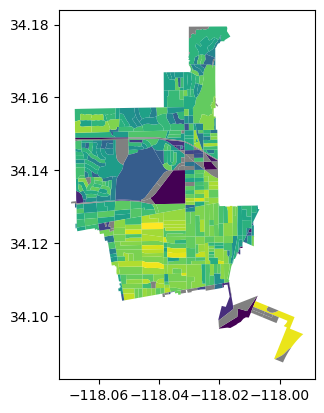

In [ ]:
arc_city_gdf_race['a_frac'] = pd.to_numeric(arc_city_gdf_race['Asian Population'])/pd.to_numeric(arc_city_gdf_race['Total Population'])
arc_city_gdf_race.plot(column = 'a_frac', missing_kwds = {'color': 'grey'})

### got city council data! joining here

In [ ]:
arcadia_council = gpd.read_file('/content/inputLayers.shp')

arcadia_council.head()

ID      AREA DISTRICT  MEMBERS LOCKED  NAME  POPULATION  HISPANIC_O  \
0   2  2.050950        1      1.0   None  None     11188.0      1550.0   
1   3  4.049896        2      1.0   None  None     11266.0      1599.0   
2   4  0.526384        3      1.0   None  None     11683.0      1897.0   
3   5  1.979729        4      1.0   None  None     11282.0      1055.0   
4   6  2.531304        5      1.0   None  None     11362.0      1334.0   

   NH_WHT  DOJ_NH_BLK  ...  F_BG_BACHE  F_BG_GRADD  F_BG_POP16  F_BG_EMPLO  \
0  1845.0       185.0  ...    0.310952    0.236787    0.802668    0.653157   
1  2895.0       208.0  ...    0.342550    0.240378    0.795611    0.563037   
2  1836.0       331.0  ...    0.388963    0.199830    0.780361    0.596577   
3  1537.0       178.0  ...    0.336634    0.173912    0.861674    0.566070   
4  1876.0       141.0  ...    0.332846    0.186485    0.816457    0.561252   

   F_BG_RENTE  F_BG_OWNED  DISTRICT_L  Shape_Leng  Shape_Area  \
0    0.423440    0.576560    1|-1.48%         0.0         0.0   
1    0.322640    0.677360    2|-0.79%         0.0         0.0   
2    0.683400    0.316600     3|2.88%         0.0         0.0   
3    0.316691    0.683309    4|-0.65%         0.0         0.0   
4    0.251547    0.748453     5|0.05%         0.0         0.0   

                                            geometry  
0  POLYGON ((-13139207 4048068, -13139257 4051239...  
1  POLYGON ((-13143228 4047552, -13143266 4049879...  
2  POLYGON ((-13143240 4045599, -13143241 4045643...  
3  POLYGON ((-13139163 4045168, -13139146 4044142...  
4  POLYGON ((-13137963 4046394, -13137951 4046398...  

[5 rows x 240 columns]

In [ ]:
print(arcadia_council.crs)
print(arc_city_gdf_race.crs)
arcadia_council = arcadia_council.to_crs(4326)
arcadia_council.crs

EPSG:3857
EPSG:4326


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

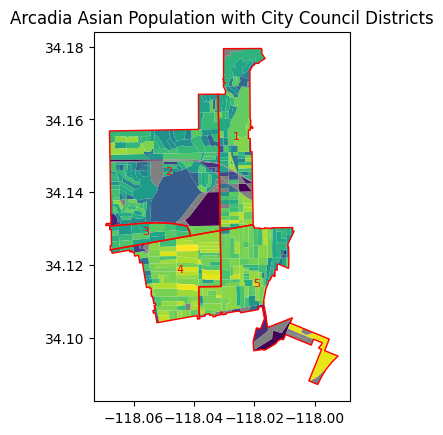

In [ ]:
#plot

arc_city_gdf_race['a_frac'] = pd.to_numeric(arc_city_gdf_race['Asian Population'])/pd.to_numeric(arc_city_gdf_race['Total Population'])
ax = arc_city_gdf_race.plot(column = 'a_frac', missing_kwds = {'color': 'grey'})

arcadia_council.plot(ax=ax, color='none', edgecolor='red', linewidth=1)

# Add labels
for idx, row in arcadia_council.iterrows():
    centroid = row.geometry.centroid  # Get the centroid of each polygon
    label = row["DISTRICT"]  # Replace with the column name for district names
    ax.text(centroid.x, centroid.y, label, fontsize=8, ha='center', color='red')  # Customize as needed

plt.title("Arcadia Asian Population with City Council Districts")
plt.show()

# Dual Graph for LA County, congressional districts

## Loading everything

In [ ]:
# right now each row is an object ID -> I want to group by block group (BG20 instead)

# Convert the 'Asian Population' column to numeric
la_gdf_race['Asian Population'] = pd.to_numeric(la_gdf_race['Asian Population'], errors='coerce')

columns = la_gdf_race[['BG20','SUP21', 'Asian Population', 'geometry', 'G20PREDBID', 'G20PRERTRU', 'POP20']]
grouped = columns.dissolve(by="BG20", aggfunc =
{
    'SUP21': 'first',
    'POP20': 'sum',
    'G20PREDBID': 'sum',
    'G20PRERTRU': 'sum',
    'Asian Population': 'sum'
}).reset_index()

# Verify the result
grouped

BG20                                           geometry SUP21  POP20  \
0     1011101  POLYGON ((-118.28735 34.25591, -118.28863 34.2...     5   2050   
1     1011102  POLYGON ((-118.29946 34.25598, -118.30024 34.2...     5   1886   
2     1011103  POLYGON ((-118.29231 34.26287, -118.29132 34.2...     5    990   
3     1011221  POLYGON ((-118.29793 34.2649, -118.29793 34.26...     5   2299   
4     1011222  POLYGON ((-118.2845 34.25589, -118.28499 34.25...     5   1429   
...       ...                                                ...   ...    ...   
6586  9800381  POLYGON ((-118.37902 33.9923, -118.38113 33.99...     2      4   
6587  9800391  POLYGON ((-118.36101 34.14104, -118.36097 34.1...     5      0   
6588  9901000  POLYGON ((-118.91589 34.03816, -118.90573 34.0...     3      0   
6589  9902000  POLYGON ((-118.47581 33.88819, -118.47683 33.8...     2      0   
6590  9903000  POLYGON ((-118.31024 33.70305, -118.31004 33.7...     4      0   

      G20PREDBID  G20PRERTRU  Asian Population  
0         509.26      416.27               165  
1         374.84      308.88               196  
2         240.10      198.95                79  
3         590.70      510.25               303  
4         408.35      338.00               101  
...          ...         ...               ...  
6586        0.00        0.00                 0  
6587        0.66        1.34                 0  
6588        0.00        0.00                 0  
6589        0.00        0.00                 0  
6590        0.00        0.00                 0  

[6591 rows x 7 columns]

In [ ]:
#getting longitude and latitude
la_gdf_race = grouped
# Function to get first coordinate pair
def get_first_coordinate(geometry):
    # Handle Polygon and MultiPolygon
    if geometry.geom_type == 'Polygon':
        return geometry.exterior.coords[0]
    elif geometry.geom_type == 'MultiPolygon':
        return geometry.geoms[0].exterior.coords[0]
la_gdf_race['longitude'], la_gdf_race['latitude'] = zip(*la_gdf_race['geometry'].apply(get_first_coordinate))
print(la_gdf_race['longitude'])
print(la_gdf_race['latitude'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      -118.287345
1      -118.299463
2      -118.292313
3      -118.297930
4      -118.284502
           ...    
6586   -118.379016
6587   -118.361006
6588   -118.915894
6589   -118.475814
6590   -118.310244
Name: longitude, Length: 6591, dtype: float64
0       34.255909
1       34.255983
2       34.262870
3       34.264903
4       34.255891
          ...    
6586    33.992300
6587    34.141045
6588    34.038158
6589    33.888192
6590    33.703048
Name: latitude, Length: 6591, dtype: float64


In [ ]:
# Save the fixed GeoDataFrame to a new shapefile
la_gdf_race["geometry"] = la_gdf_race["geometry"].buffer(0)

#saving so I don't have to run again
save_path = '/content/drive/My Drive/la_fixed.shp'
la_gdf_race.to_file(save_path)

la_graph = Graph.from_file("/content/drive/My Drive/la_fixed.shp")

<ipython-input-182-0d88d6c5ebe3>:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  la_gdf_race.to_file(save_path)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Asian Population' to 'Asian Popu'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/gerrychain/graph/graph.py:406: UserWarning: Found islands (degree-0 nodes). Indices of islands: {5453}
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [ ]:
# Save the Graph object to a file
graph_save_path = '/content/drive/My Drive/la_graph.pkl'
with open(graph_save_path, 'wb') as file:
    pickle.dump(la_graph, file)

In [ ]:
#load up without running

# Load the shapefile
shapefile_path = '/content/drive/My Drive/la_fixed.shp'
la_gdf_race = gpd.read_file(shapefile_path)

# Define the path to the saved graph
graph_path = '/content/drive/My Drive/la_graph'

# Reload the graph
with open(graph_save_path, 'rb') as file:
    la_graph = pickle.load(file)

In [ ]:
print(la_graph.nodes()[0].keys())

dict_keys(['boundary_node', 'area', 'BG20', 'SUP21', 'POP20', 'G20PREDBID', 'G20PRERTRU', 'Asian Popu', 'longitude', 'latitude', 'geometry'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("Is this dual graph connected? ", nx.is_connected(la_graph))
print("Is this dual graph planar? ", nx.is_planar(la_graph))
print("Number of Nodes: ", len(la_graph.nodes()))
print("Number of Edges: ", len(la_graph.edges()))

Is this dual graph connected?  False
Is this dual graph planar?  False
Number of Nodes:  6591
Number of Edges:  17785


In [ ]:
# List of populations at each node
list_of_pop = [la_graph.nodes()[v]['POP20'] for v in la_graph.nodes()]


# Total population
total_pop = sum(list_of_pop)

print("Total Population: ", total_pop)

Total Population:  10014009


## Make an initial districting plan and graph

In [ ]:
num_dist = 5 # Number of Congressional Districts in LA County
ideal_pop = total_pop/num_dist
pop_tolerance = 0.02
initial_plan = recursive_tree_part(la_graph, range(num_dist), ideal_pop, 'POP20', pop_tolerance, 10)

In [ ]:
# Save the Graph object to a file
graph_save_path = '/content/drive/My Drive/la_initial_plan.pkl'
with open(graph_save_path, 'wb') as file:
    pickle.dump(initial_plan, file)

In [ ]:
# Open the Initial Plan
graph_save_path = '/content/drive/My Drive/la_initial_plan.pkl'
with open(graph_save_path, 'rb') as file:
    initial_plan = pickle.load(file)

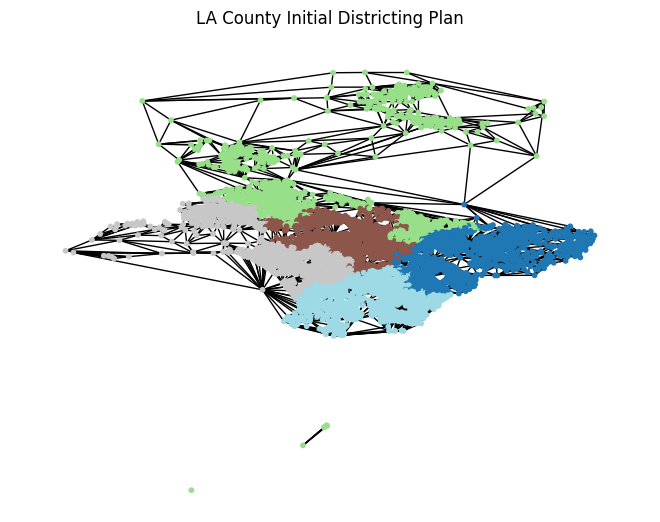

In [ ]:
node_locations = { v : ( float(la_graph.nodes()[v]["longitude"]), float(la_graph.nodes()[v]["latitude"])) for v in la_graph.nodes() }
plt.figure()
nx.draw(la_graph, node_size = 10,  node_color = [initial_plan[v] for v in la_graph.nodes()], pos = node_locations, cmap="tab20")
plt.title('LA County Initial Districting Plan')
plt.show()

In [ ]:
cutedges = 0

for e in la_graph.edges():
  if initial_plan[e[0]] != initial_plan[e[1]]:
    cutedges += 1

print("Number of cutedges in initial_plan: ", cutedges)

Number of cutedges in initial_plan:  654


In [ ]:
#population of each district
dist_pops = [0]*num_dist
for v in la_graph.nodes():
  dist = initial_plan[v]
  dist_pops[dist] = dist_pops[dist] + la_graph.nodes()[v]['POP20']

print("Populations of Districts: ", dist_pops)

Populations of Districts:  [1974128, 1994293, 2037642, 2000973, 2006973]


## Set up random walk based on initial districting plan, run for double the amount of steps (10k vs 20k)

In [ ]:
#Set up partition object
initial_partition = Partition(
    la_graph, #dual graph
    assignment = initial_plan, #initial districting plan
    updaters = {
        "our cut edges": cut_edges,
        "district population": Tally("POP20", alias = "district population"),
        "district AsianPop": Tally("Asian Popu", alias = "district AsianPop"), #Asian Population
        "Biden Votes": Tally("G20PREDBID", alias = "Biden Votes"),
        "Trump Votes": Tally("G20PRERTRU", alias = "Trump Votes")
    }
)

In [ ]:
# step in random walk

rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "POP20", ## What data describes population?
                      pop_target = ideal_pop, ## What the target/ideal population is for each district
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                       node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [ ]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition,
    pop_tolerance,
    pop_key = "district population"

    )

In [ ]:
# Creating the chain
our_random_walk = MarkovChain(
    proposal = rw_proposal,
    constraints = [population_constraint],
    accept = always_accept, #accepts every proposed plan that meets population criteria,
    initial_state = initial_partition,
    total_steps = 20000
)

## Running Random Walk

In [ ]:
cutedge_ensemble = []
amaj_ensemble = []
d_ensemble = []
apop = []
step = 0

for part in our_random_walk:
    step += 1
    print("step", step)
    # Add cutedges to cutedges ensemble
    cutedge_ensemble.append(len(part["our cut edges"]))

    # Calculate number of black-majority districts
    # Add to ensemble
    num_maj_asian = 0
    apop_this_step = []

    for i in range(num_dist):
      a_perc = part["district AsianPop"][i] / part["district population"][i]
      apop_this_step.append(a_perc)
      if a_perc >= 0.5:
        num_maj_asian = num_maj_asian + 1

    apop_this_step.sort()
    apop.append(apop_this_step)
    amaj_ensemble.append(num_maj_asian)

    # Calculate number of districts with more Democratic votes than Republican votes
    d = 0

    for i in range(num_dist):
      if part["Trump Votes"][i] <  part["Biden Votes"][i]:
        d = d + 1
    d_ensemble.append(d)


print(cutedge_ensemble)
print(amaj_ensemble)
print(d_ensemble)
print(apop)

#saving these in a pickle so I don't have to run random walk again
with open('/content/drive/My Drive/ensemble_outputs_20k.pkl', 'wb') as f:
    pickle.dump({
        'cutedge_ensemble': cutedge_ensemble,
        'amaj_ensemble': amaj_ensemble,
        'd_ensemble': d_ensemble,
        'apop': apop
    }, f)

Streaming output truncated to the last 5000 lines.
step 15005
step 15006
step 15007
step 15008
step 15009
step 15010
step 15011
step 15012
step 15013
step 15014
step 15015
step 15016
step 15017
step 15018
step 15019
step 15020
step 15021
step 15022
step 15023
step 15024
step 15025
step 15026
step 15027
step 15028
step 15029
step 15030
step 15031
step 15032
step 15033
step 15034
step 15035
step 15036
step 15037
step 15038
step 15039
step 15040
step 15041
step 15042
step 15043
step 15044
step 15045
step 15046
step 15047
step 15048
step 15049
step 15050
step 15051
step 15052
step 15053
step 15054
step 15055
step 15056
step 15057
step 15058
step 15059
step 15060
step 15061
step 15062
step 15063
step 15064
step 15065
step 15066
step 15067
step 15068
step 15069
step 15070
step 15071
step 15072
step 15073
step 15074
step 15075
step 15076
step 15077
step 15078
step 15079
step 15080
step 15081
step 15082
step 15083
step 15084
step 15085
step 15086
step 15087
step 15088
step 15089
step 15090
ste

## Graphs

In [ ]:
with open('/content/drive/My Drive/ensemble_outputs_20k.pkl', 'rb') as f:
    data = pickle.load(f)
    cutedge_ensemble = data['cutedge_ensemble']
    amaj_ensemble = data['amaj_ensemble']
    d_ensemble = data['d_ensemble']
    apop = data['apop']

In [ ]:
#get 10k steps
cutedge_ensemble_10k = cutedge_ensemble[0:10000]
amaj_ensemble_10k = amaj_ensemble[0:10000]
d_ensemble_10k = d_ensemble[0:10000]
apop_10k = apop[0:10000]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


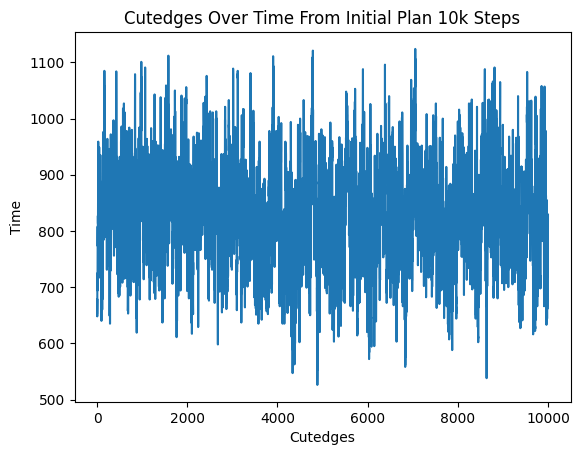

In [ ]:
#cutedges over time from initial plan 10k steps
plt.figure()
plt.plot(cutedge_ensemble_10k)
plt.xlabel('Cutedges')
plt.ylabel('Time')
plt.title('Cutedges Over Time From Initial Plan 10k Steps')
plt.show()

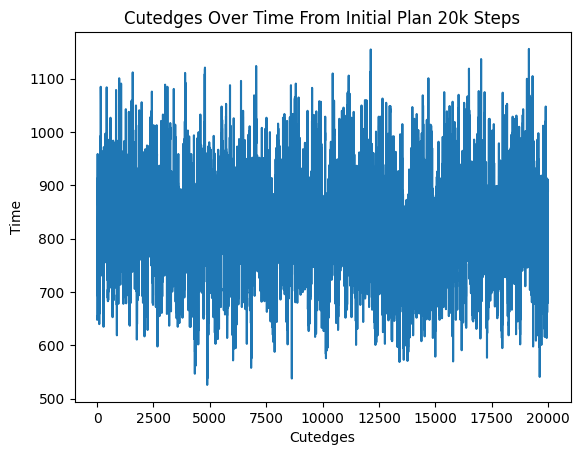

In [ ]:
#cutedges over time from intial plan 20k steps
plt.figure()
plt.plot(cutedge_ensemble)
plt.xlabel('Cutedges')
plt.ylabel('Time')
plt.title('Cutedges Over Time From Initial Plan 20k Steps')
plt.show()

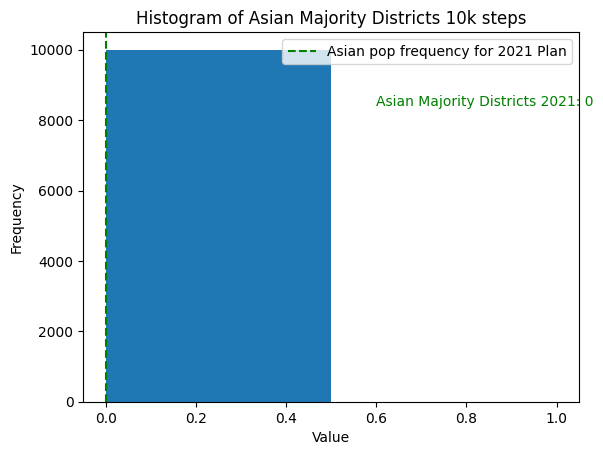

In [ ]:
#Asian majority districts 10k steps
plt.figure()
plt.hist(amaj_ensemble_10k, bins =[0,0.5,1])

# Add a vertical line or annotation for the count of majority Asian districts (0)
plt.axvline(x=0, color='green', linestyle='--', label='Asian pop frequency for 2021 Plan')
plt.text(0.6, plt.ylim()[1]*0.8, f'Asian Majority Districts 2021: {0}', color='green')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Asian Majority Districts 10k steps')
plt.legend()

# Show the plot
plt.show()

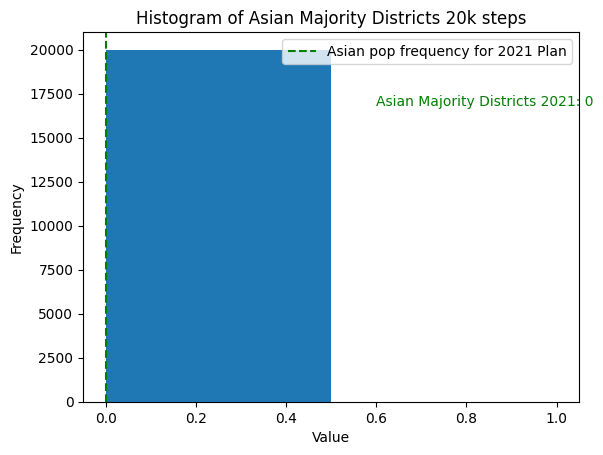

In [ ]:
#Asian majority districts 20k steps
plt.figure()
plt.hist(amaj_ensemble, bins = [0,0.5,1])

# Add a vertical line or annotation for the count of majority Asian districts
plt.axvline(x=0, color='green', linestyle='--', label='Asian pop frequency for 2021 Plan')
plt.text(0.6, plt.ylim()[1]*0.8, f'Asian Majority Districts 2021: {0}', color='green')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Asian Majority Districts 20k steps')
plt.legend()

plt.show()

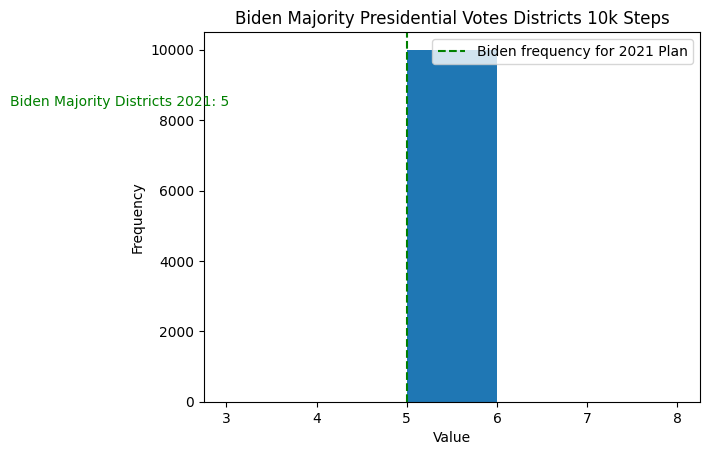

In [ ]:
#democratic districts 10k steps
plt.figure()
plt.hist(d_ensemble_10k, bins = [3,4,5,6,7,8])

# Add a vertical line or annotation for the count of majority Biden districts (5)
plt.axvline(x=5, color='green', linestyle='--', label='Biden frequency for 2021 Plan')
plt.text(0.6, plt.ylim()[1]*0.8, f'Biden Majority Districts 2021: {5}', color='green')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Biden Majority Presidential Votes Districts 10k Steps')
plt.legend()
plt.show()

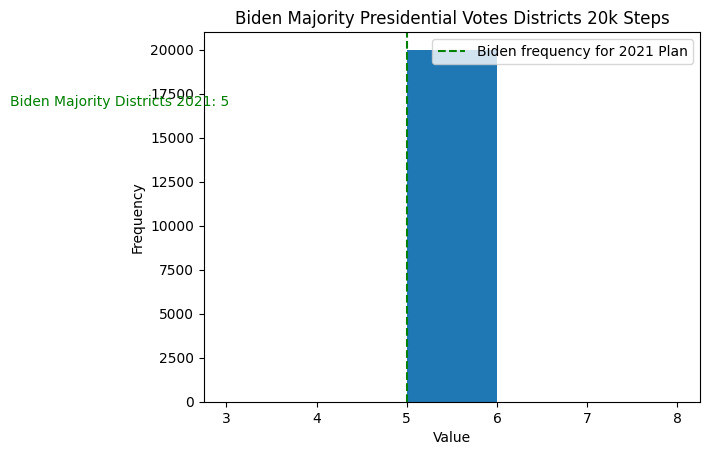

In [ ]:
#democratic districts (double run)
plt.figure()
plt.hist(d_ensemble, bins = [3,4,5,6,7,8])

# Add a vertical line or annotation for the count of majority Biden districts (5)
plt.axvline(x=5, color='green', linestyle='--', label='Biden frequency for 2021 Plan')
plt.text(0.6, plt.ylim()[1]*0.8, f'Biden Majority Districts 2021: {5}', color='green')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Biden Majority Presidential Votes Districts 20k Steps')
plt.legend()
plt.show()

Boxplots!

In [ ]:
la_by_dist

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SUP21                                           geometry  Asian Population  \
0     1  POLYGON ((-118.28402 34.03712, -118.28402 34.0...            500087   
1     2  POLYGON ((-118.4662 33.81744, -118.46682 33.81...            206808   
2     3  POLYGON ((-118.64836 33.98673, -118.65017 33.9...            240375   
3     4  MULTIPOLYGON (((-118.56142 33.08107, -118.5526...            268521   
4     5  POLYGON ((-118.62565 34.27489, -118.62586 34.2...            284193   

     POP20  G20PRERTRU  G20PREDBID    a_frac  R_to_D_ratio R_or_D  
0  1975618   184901.21   543699.09  0.253129      0.340080  Biden  
1  2011826   131187.72   625009.89  0.102796      0.209897  Biden  
2  2055731   245335.54   693501.78  0.116929      0.353763  Biden  
3  2077325   259951.50   596139.86  0.129263      0.436058  Biden  
4  1893509   324132.41   570479.96  0.150088      0.568175  Biden

In [ ]:
afrac_21 = la_by_dist['a_frac'].to_list()
afrac_21.sort()
print(afrac_21)

[0.10279616626885228, 0.11692920912317809, 0.12926287412898801, 0.15008801120036927, 0.2531294005217608]


[[0.09678891 0.13813868 0.14118967 0.14216684 0.23190188]
 [0.09678891 0.11762587 0.14216684 0.16123835 0.23190188]
 [0.09678891 0.11762587 0.14216684 0.19071629 0.20117424]
 ...
 [0.09529307 0.11886749 0.13583466 0.15870311 0.23940228]
 [0.1053079  0.11886749 0.1259789  0.15870311 0.23940228]
 [0.09445969 0.11886749 0.13629868 0.15870311 0.23940228]]


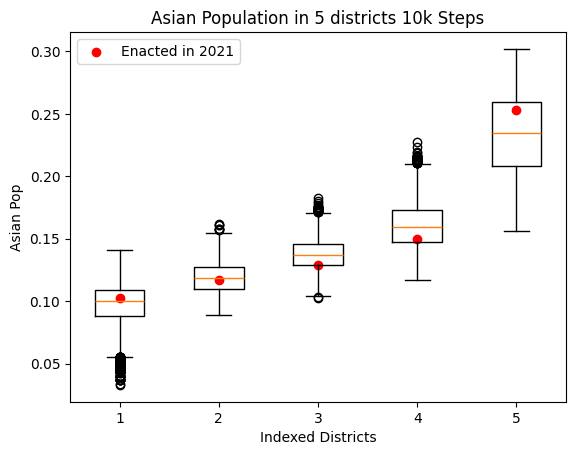

In [ ]:
a = np.array(apop_10k)
print(a)
plt.figure()
plt.boxplot(a)
plt.scatter(x=range(1, 6), y=afrac_21, color="red", label='Enacted in 2021')
plt.xlabel('Indexed Districts')
plt.ylabel('Asian Pop')
plt.title('Asian Population in 5 districts 10k Steps')
plt.legend()
plt.show()

[[0.09678891 0.13813868 0.14118967 0.14216684 0.23190188]
 [0.09678891 0.11762587 0.14216684 0.16123835 0.23190188]
 [0.09678891 0.11762587 0.14216684 0.19071629 0.20117424]
 ...
 [0.08821063 0.1354094  0.14545719 0.15635786 0.22235497]
 [0.08821063 0.13532906 0.14548332 0.15635786 0.22235497]
 [0.08821063 0.13688326 0.14390154 0.15635786 0.22235497]]


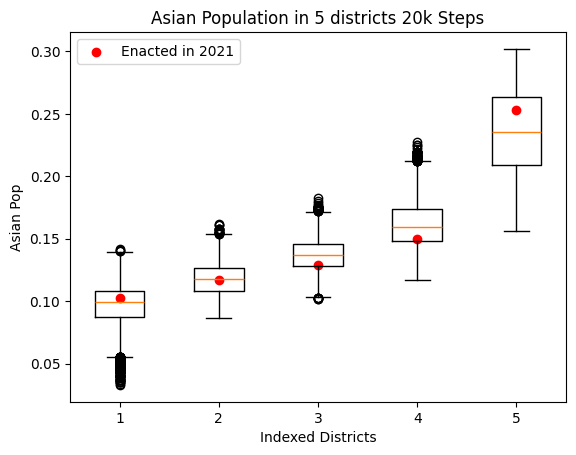

In [ ]:
a = np.array(apop)
print(a)
plt.figure()
plt.boxplot(a)
plt.scatter(x=range(1, 6), y=afrac_21, color="red", label='Enacted in 2021')
plt.xlabel('Indexed Districts')
plt.ylabel('Asian Pop')
plt.title('Asian Population in 5 districts 20k Steps')
plt.legend()
plt.show()